In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.nn import Module, Conv1d, Linear
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial

from lafomo.utilities.data import MatReader
from lafomo.datasets import ToyTimeSeries

In [2]:
num_outputs = 10
basal_rate = 0.1 + 0.3 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
sensitivity = 2 + 5 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
decay_rate = 0.2 + 2 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)


In [20]:
ntrain = 15

datasets = list()
for i in range(ntrain):
    dataset = ToyTimeSeries(num_outputs, 1, 10, params=[basal_rate, sensitivity, decay_rate], plot=False)
    datasets.append(dataset)

In [296]:
train_a = torch.cat([dataset.m_observed for dataset in datasets]).permute(0, 2, 1)
T_in = 11
grid = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntrain, 1, 1) # (1, 32, 32, 40, 1)

x_train = torch.cat([grid, train_a], dim=-1)
y_train = torch.cat([dataset.f_observed for dataset in datasets]).permute(0, 2, 1)
print('y', y_train.shape)
print('x', x_train.shape)
batch_size = 15
train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                          batch_size=batch_size, shuffle=True)

y torch.Size([15, 11, 1])
x torch.Size([15, 11, 11])


In [297]:
#Complex multiplication
def compl_mul1d(a, b):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    return torch.einsum('bix,iox->box', a, b)


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1).type(torch.complex64))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels, x.size(-1)//2 + 1, device=x.device)
        out_ft[:, :, :self.modes1] = compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


In [298]:
class SimpleBlock1d(Module):
    def __init__(self, modes, width):
        super(SimpleBlock1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 = Linear(11, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = Conv1d(self.width, self.width, 1)
        self.w1 = Conv1d(self.width, self.width, 1)
        self.w2 = Conv1d(self.width, self.width, 1)
        self.w3 = Conv1d(self.width, self.width, 1)


        self.fc1 = Linear(self.width, 128)
        self.fc2 = Linear(128, 1)

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net1d(Module):
    def __init__(self, modes, width):
        super(Net1d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock1d(modes, width)


    def forward(self, x):
        x = self.conv1(x)
        return x#.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c
#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [299]:
width = 20
modes = 4
model = Net1d(modes, width)
print(model.count_params())

11137


In [300]:
learning_rate = 1e-3
gamma = 0.5
step_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
epochs = 10
myloss = LpLoss(size_average=False)

In [318]:
for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        # x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        print(x.shape, out.shape, y.shape)
        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    # with torch.no_grad():
    #     for x, y in test_loader:
    #         x, y = x.cuda(), y.cuda()
    #
    #         out = model(x)
    #         test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    # test_l2 /= ntest

    print(ep, train_mse,  train_l2, test_l2)

torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch.Size([15, 11, 1])
0 0.14626476168632507 0.3663055419921875 0.0
torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch.Size([15, 11, 1])
1 0.13902819156646729 0.35802593231201174 0.0
torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch.Size([15, 11, 1])
2 0.1348535120487213 0.3582077344258626 0.0
torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch.Size([15, 11, 1])
3 0.13477924466133118 0.3596274058024089 0.0
torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch.Size([15, 11, 1])
4 0.13321538269519806 0.35240332285563153 0.0
torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch.Size([15, 11, 1])
5 0.13794411718845367 0.3557927449544271 0.0
torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch.Size([15, 11, 1])
6 0.13495256006717682 0.35241724650065104 0.0
torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch.Size([15, 11, 1])
7 0.12961086630821228 0.3490499178568522 0.0
torch.Size([15, 11, 11]) torch.Size([15, 11, 1]) torch

torch.Size([15, 11, 11]) torch.Size([15, 11, 1])
torch.Size([15, 11, 1])


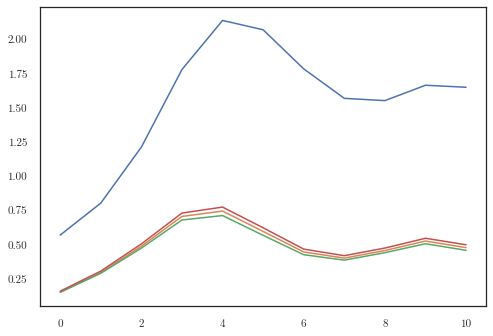

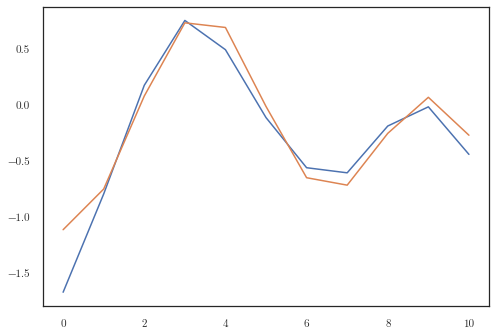

In [319]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
for i in range(1, 5):
    plt.plot(x[0, :, i])#.shape, y.shape)

plt.figure()
plt.plot(y[0, :, 0])

out = model(x)
print(out.shape)
plt.plot(out[0, :, 0].detach())


In [310]:
# torch.save(model, 'model/ns_fourier_burgers_8192')
pred = torch.zeros(y_train.shape)
index = 0
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        # x, y = x.cuda(), y.cuda()

        out = model(x)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

NameError: name 'test_loader' is not defined

/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


<HDF5 file "ns_V1e-3_N5000_T50.mat" (mode r+)>
<HDF5 dataset "u": shape (50, 64, 64, 5000), type "<f4">
10 0.0025 100 0.5
torch.Size([100, 32, 32, 40, 10])
torch.Size([1, 32, 32, 40, 1]) torch.Size([1, 32, 32, 40, 1])
torch.Size([100, 32, 32, 40, 1])
torch.Size([100, 32, 32, 40, 13])


In [ ]:
path = '../../data/ns_V1e-3_N5000_T50.mat'
from h5py import File

# u shape (50, 64, 64, 5000)
# a shape (64, 64, 5000)
# t shape (50, 1)

f = File(path)
print(f)
print(f['u'])

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)


runtime = np.zeros(2, )

ntrain = 100
sub = 1
S = 64 // sub
T_in = 10
T = 40
S = 32

# train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
# train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
train_a = torch.rand((100, 32, 32, 50))[:, :, :, :T_in]
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
print(train_a.shape)
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# 32
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
# 1, 32, 32, 40, 1 (1, S, S, T, 1)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
# (1, S, S, T, 1)
print(gridt.shape, gridx.shape)
# for t in range(10):
#     plt.figure()
#     plt.imshow(gridy.squeeze()[:, :, t])
print(gridx.repeat([ntrain,1,1,1,1]).shape)
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
print(train_a.shape)

torch.Size([100, 32, 32, 40, 13])


In [ ]:
# This part checks our complex multiplication code:
def compl_mul1d(a, b):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    op = partial(torch.einsum, "bix,iox->box")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

weights1_sep = torch.rand(20, 20, 4, 2)
weights1_sep = torch.rand(64, 64, 4, 2)
weights1 = weights1_sep[:, :, :, 0] + weights1_sep[:, :, :, 1] * 1j
x = torch.randn((15, 20, 11))
x = torch.randn((100, 64, 1024))
print(x.shape)

In [ ]:
x_ft = torch.fft.rfft(x)
x_ft_sep = torch.stack([
    torch.real(x_ft),
    torch.imag(x_ft)
    ], dim=-1)
print(x_ft_sep.shape)

In [ ]:
mul2 = compl_mul1d(x_ft_sep[:, :, :4], weights1_sep)
print(mul2)

In [ ]:
op = partial(torch.einsum, "bix,iox->box")
    # return torch.stack([
    #     op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
    #     op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    # ], dim=-1)

A = x_ft[:, :, :4]#.unsqueeze(1)
B = weights1#.unsqueeze(0)
print(A.shape, B.shape)
print(A.type())
# print(B.type(torch.complex64))
mul = op(A, B.type(torch.complex64))
# mul = torch.matmul(A, B)
print(mul.shape, mul2.shape)

print(mul2[where])



In [ ]:
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

grid = np.linspace(0, 2*np.pi, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.randn(ntrain, s, 1)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)

modes = 16
width = 64
print(x_train.shape)
x = Linear(2, width)(x_train).permute(0, 2, 1)
print(x.shape)